### 1. Importing libraries

In [1]:
import pandas as pd
# import modin.pandas as pd
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from yellowbrick.cluster import KElbowVisualizer
import datetime as dt
import numpy as np
from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

C:\Users\nishant\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2. Read the data

In [2]:
df=pd.read_excel("Civ.xlsx")
df.head()

,PLAYERID,INSTALLDATE,ACTIVEDAYS,LASTACTIVEDAY,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,VIKINGS,RISE_AND_FALL,AUSTRALIA
0,3316379,2018-01-05,1,2018-01-05,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,3316386,2018-01-05,3,2018-01-09,LEADER_TRAJAN,CIVILIZATION_ROME,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3316394,2018-01-05,115,2018-07-08,LEADER_T_ROOSEVELT,CIVILIZATION_AMERICA,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,3888460,2018-03-04,112,2019-10-05,LEADER_HOJO,CIVILIZATION_JAPAN,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,3940600,2018-03-12,1,2018-03-12,LEADER_PALA,CIVILIZATION_PALA,NaT,NaT,2018-03-12,NaT,NaT,NaT,NaT,NaT


In [3]:
# check if datatypes are read correctly
df.dtypes

PLAYERID                             int64
INSTALLDATE                 datetime64[ns]
ACTIVEDAYS                           int64
LASTACTIVEDAY               datetime64[ns]
LEADERMOSTSELECTED                  object
CIVILIZATIONMOSTSELECTED            object
POLAND                      datetime64[ns]
NUBIA                       datetime64[ns]
KHMER_AND_INDONESIA         datetime64[ns]
GATHERING_STORM             datetime64[ns]
PERSIA_AND_MACEDON          datetime64[ns]
VIKINGS                     datetime64[ns]
RISE_AND_FALL               datetime64[ns]
AUSTRALIA                   datetime64[ns]
dtype: object

## 3. A bit of wrangling

#### I make indicators for each player, representing installation of DLC or EP

In [4]:
cols_dlc=['POLAND','NUBIA','KHMER_AND_INDONESIA','PERSIA_AND_MACEDON','VIKINGS','AUSTRALIA']
cols_ep=['GATHERING_STORM','RISE_AND_FALL']
cols_purchase=['INSTALLDATE']+cols_dlc+cols_ep

df['n_ep_response']=2-df[cols_ep].isna().sum(axis=1)                                    # no. of EP installations
df['n_dlc_response']=6-df[cols_dlc].isna().sum(axis=1)                                  # no. of DLC installations
df['n_response']=df['n_dlc_response']+df['n_ep_response']                               # no. of installations

df['ep_and_dlc_responder']=np.logical_and(df['n_ep_response'],df['n_dlc_response'])*1   # binary AND flag
df['ep_or_dlc_responder']=np.logical_or(df['n_ep_response'],df['n_dlc_response'])*1     # binary OR flag

<font color=blue><h3>
For better understanding, I convert dates to an integer representing the number of days passed since the 'beginning of time'. <br/><br/>
I define 'beginning of time' as the first ever date when the game was installed.
    </h3></font>

In [5]:
df_days=df.select_dtypes('datetime')-df.INSTALLDATE.min() #subtract the first install date from all datetime columns
for col in df_days.columns:
    df_days[col]=df_days[col].dt.days   #convert datetime to numeric format
df_days.fillna(-1, inplace=True)        #replace nulls with -1, representing that the player never installed the content
df_days=pd.concat([df.select_dtypes(exclude='datetime'),df_days],axis=1)  #adding other info from original data                    

#### Let's take a look at the data, shall we!?

In [6]:
df_days.head(10)

,PLAYERID,ACTIVEDAYS,LEADERMOSTSELECTED,CIVILIZATIONMOSTSELECTED,n_ep_response,n_dlc_response,n_response,ep_and_dlc_responder,ep_or_dlc_responder,INSTALLDATE,LASTACTIVEDAY,POLAND,NUBIA,KHMER_AND_INDONESIA,GATHERING_STORM,PERSIA_AND_MACEDON,VIKINGS,RISE_AND_FALL,AUSTRALIA
0,3316379,1,LEADER_GILGAMESH,CIVILIZATION_SUMERIA,0,0,0,0,0,500,500,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,3316386,3,LEADER_TRAJAN,CIVILIZATION_ROME,0,0,0,0,0,500,504,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,3316394,115,LEADER_T_ROOSEVELT,CIVILIZATION_AMERICA,0,0,0,0,0,500,684,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3888460,112,LEADER_HOJO,CIVILIZATION_JAPAN,0,0,0,0,0,558,1138,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,3940600,1,LEADER_PALA,CIVILIZATION_PALA,0,1,1,0,1,566,566,-1.0,-1.0,566.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,3316418,2,LEADER_QIN,CIVILIZATION_CHINA,0,0,0,0,0,500,501,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,3316426,7,LEADER_HOJO,CIVILIZATION_JAPAN,0,0,0,0,0,500,796,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,4044834,7,LEADER_BARBAROSSA,CIVILIZATION_GERMANY,1,0,1,0,1,606,637,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,606.0,-1.0
8,3860763,1,LEADER_CLEOPATRA,CIVILIZATION_EGYPT,0,0,0,0,0,550,550,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,3316450,6,LEADER_QIN,CIVILIZATION_CHINA,0,0,0,0,0,500,548,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## 4. Time for some Exploratory Analysis

### 4.1 Player Response

#### How many players installed something?

<AxesSubplot:ylabel='ep_or_dlc_responder'>

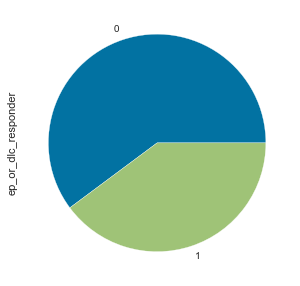

In [7]:
df_days.ep_or_dlc_responder.value_counts().plot(kind='pie',figsize=(5,5))

<h4><font color=blue> Almost a 40% of the players installed an add-on!
</font></h4>

#### How many Expansion Packs were installed?

<AxesSubplot:>

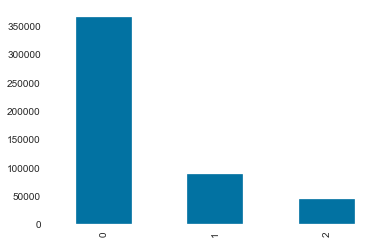

In [8]:
df_days.n_ep_response.value_counts().plot(kind='bar',figsize=(6,4))

#### And how many DLCs were installed?

<AxesSubplot:>

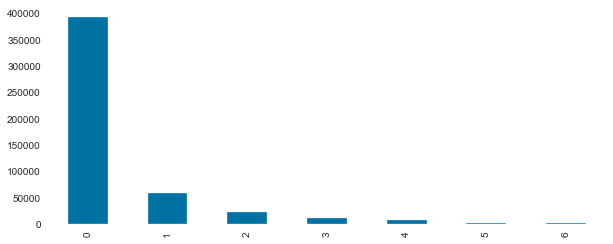

In [9]:
df_days.n_dlc_response.value_counts().plot(kind='bar',figsize=(10,4))

### 4.2 Player Activity
#### How frequently do players play?

<AxesSubplot:>

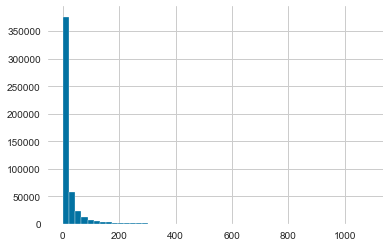

In [10]:
df_days.ACTIVEDAYS.hist(bins=50)

#### hmm, that doesn't give a lot of info, let me convert y-axis to log-scale

<AxesSubplot:ylabel='Frequency'>

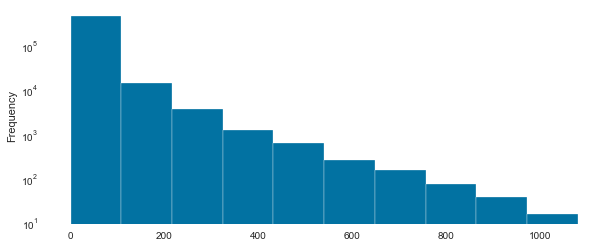

In [11]:
df_days.ACTIVEDAYS.plot(kind='hist',logy=True,figsize=(10,4))

#### looking at both the above charts, activedays does fall exponentially

### 4.3 Are responders really different from non-responders? 

In [12]:
df_days.groupby('ep_or_dlc_responder').agg({'INSTALLDATE':[np.mean,np.median,np.var],
                                           'LASTACTIVEDAY':[np.mean,np.median,np.var],
                                           'ACTIVEDAYS':[np.mean,np.median,np.var]}).round(1)

INSTALLDATE                  LASTACTIVEDAY         \
                           mean median       var          mean median   
ep_or_dlc_responder                                                     
0                         499.6    498  127625.8         696.0    788   
1                         504.3    501  126292.2         920.4    990   

                              ACTIVEDAYS                 
                          var       mean median     var  
ep_or_dlc_responder                                      
0                    115998.8       11.9      5   659.4  
1                     52594.2       41.2     18  4611.7

Note that in the above table, dates/days are relative to days passed since first-ever install date in the data.

#### LASTACTIVEDAY and ACTIVEDAYS seem different for responders and non-responders, INSTALLDATE is not.
#### I perform a statistical test to confirm difference in means.

#### NULL Hypothesis: Metric means of responder and non-responders are same

In [13]:
# since the variances are different, I perform welch's t-test
cat1 = df_days[df_days['ep_or_dlc_responder']==0]    # non-responders
cat2 = df_days[df_days['ep_or_dlc_responder']==1]    # responders
print('INSTALLDATE\t',ttest_ind(cat1['INSTALLDATE'], cat2['INSTALLDATE'], equal_var=False))
print('LASTACTIVEDAY\t',ttest_ind(cat1['LASTACTIVEDAY'], cat2['LASTACTIVEDAY'], equal_var=False))
print('ACTIVEDAYS\t',ttest_ind(cat1['ACTIVEDAYS'], cat2['ACTIVEDAYS'], equal_var=False))

INSTALLDATE	 Ttest_indResult(statistic=-4.6216574703937034, pvalue=3.8079705070661843e-06)
LASTACTIVEDAY	 Ttest_indResult(statistic=-278.4072964665853, pvalue=0.0)
ACTIVEDAYS	 Ttest_indResult(statistic=-184.2356523820133, pvalue=0.0)


<h4> <font color=blue>p-value for all is less than 0.01, meaning that we can reject the null hypothesis with more than 99% confidence.
<br/><br/>Thus, the the two populations are actually different.</font></h4>

### 4.4 Do the responders differ in how they select LEADER	and CIVILIZATION?

In [14]:
# Leaders selected by non-responders
df_days[df_days.ep_or_dlc_responder==0].LEADERMOSTSELECTED.value_counts()

LEADER_QIN                          35768
LEADER_T_ROOSEVELT                  31873
LEADER_TRAJAN                       27628
LEADER_BARBAROSSA                   23314
LEADER_HOJO                         18384
                                    ...  
LEADER_EURON_GREYJOY                    1
LEADER_WITCH_KING                       1
LEADER_AKIRA_AKIRA_LEADER_CUSTOM        1
LEADER_MERIDA                           1
LEADER_TUFAN                            1
Name: LEADERMOSTSELECTED, Length: 417, dtype: int64

In [15]:
# Leaders selected by responders
df_days[df_days.ep_or_dlc_responder==1].LEADERMOSTSELECTED.value_counts()

LEADER_QIN                  22418
LEADER_TRAJAN               14829
LEADER_BARBAROSSA           13383
LEADER_T_ROOSEVELT          12587
LEADER_ALEXANDER             9425
                            ...  
LEADER_BWH_PEASHY               1
LEADER_FOR                      1
LEADER_DGS_LEADER_CUSTOM        1
LEADER_DAV_KARL_CUSTOM          1
LEADER_SC_LENIN                 1
Name: LEADERMOSTSELECTED, Length: 602, dtype: int64

#### While most popular Leaders are similar in both the groups (see top 5 above), Responders tried 602 leaders, as opposed to 417 in non-reponders.  However, we have not normalised using population count yet.


In [16]:
# Civilization selected by non-responders
df_days[df_days.ep_or_dlc_responder==0].CIVILIZATIONMOSTSELECTED.value_counts()

CIVILIZATION_CHINA               35842
CIVILIZATION_AMERICA             31905
CIVILIZATION_ROME                27647
CIVILIZATION_GERMANY             23493
CIVILIZATION_JAPAN               18404
                                 ...  
CIVILIZATION_SCOTLAND                1
CIVILIZATION_TEMERIA                 1
CIVILIZATION_PJK_KANMUSU009          1
CIVILIZATION_CYRODILIC_EMPIRE        1
CIVILIZATION_DPRT                    1
Name: CIVILIZATIONMOSTSELECTED, Length: 297, dtype: int64

In [17]:
# Civilization selected by responders
df_days[df_days.ep_or_dlc_responder==1].CIVILIZATIONMOSTSELECTED.value_counts()

CIVILIZATION_CHINA              22590
CIVILIZATION_ROME               14871
CIVILIZATION_GERMANY            13582
CIVILIZATION_AMERICA            12664
CIVILIZATION_ENGLAND             9528
                                ...  
CIVILIZATION_VALE                   1
CIVILIZATION_BNL                    1
CIVILIZATION_WFRF                   1
CIVILIZATION_RELIC_ENIG_MAYA        1
CIVILIZATION_GEDEMO_NOONGAR         1
Name: CIVILIZATIONMOSTSELECTED, Length: 429, dtype: int64

#### Same as before, responders check out more varied civilizations than non-responders. Still not normalised, though.
#### This means that possibly, responders tend to explore the game more! 
#### Let's normalise to confirm!

In [18]:
df_expl=df_days.groupby('n_response').agg({'PLAYERID':['count'],'CIVILIZATIONMOSTSELECTED':'nunique','LEADERMOSTSELECTED':'nunique'})
df_expl['Civ_per_player']=df_expl.iloc[:,1]/df_expl.iloc[:,0]
df_expl['Leaders_per_player']=df_expl.iloc[:,2]/df_expl.iloc[:,0]
df_expl

,PLAYERID,CIVILIZATIONMOSTSELECTED,LEADERMOSTSELECTED,Civ_per_player,Leaders_per_player
,count,nunique,nunique,,
n_response,,,,,
0,300896,297,417,0.000987,0.001386
1,110191,310,428,0.002813,0.003884
2,47032,280,376,0.005953,0.007995
3,17588,170,213,0.009666,0.012111
4,10230,128,151,0.012512,0.014761
5,6311,96,108,0.015212,0.017113
6,4472,76,94,0.016995,0.021020
7,2026,62,73,0.030602,0.036032


#### <font color=blue>Higher the Response, higher the distinct civilizations or leaders interacted with.

#### Maybe target them specifically with new ones!</font>

## 5. Customer Segmentation

### Having segmented the players in two already- Responders and Non-responders, I wish to further segment the Responders.
### I use a modified RFM strategy for customer segmentation

#### In addition to Recency, Frequency and Monetary metrics, I include two more metrics as below:

<font color=blue><h4>
Recency:             LASTACTIVEDAY - When was the last day player logged in?
<br/>
    
Frequency:           ACTIVEDAY     - For how many days was the player active? 

Monetary:            total_spent   - How much has the player spent yet?

Response History:    n_response    - Number of Expansion Packs or DLCs already installed.

Purchase Frequency:  purchase_freq  - What is the average number of days in which a player installs a new pack?
    </h4></font>

In [19]:
# Separating Responders for further analysis
df_responders=df_days[df_days.ep_or_dlc_responder==1]

### 5.1 Calculating money spent
<font color=blue><h4>I obtained the prices from 2k store website</h4></font>

In [20]:
prices={'Base':50,'GATHERING_STORM':40,'RISE_AND_FALL':30,'POLAND':5,'NUBIA':5,'KHMER_AND_INDONESIA':9,
    'PERSIA_AND_MACEDON':9,'VIKINGS':5,'AUSTRALIA':5,'DLCPack':15.50,'Game_EP_DLC':120,'Game_DLCs':80}

In [21]:
# Defining flags if pack was installed

#bought all-in-one Platinum edition, if all install dates are equal
df_responders['bought_Game_EP_DLC']=df_responders[cols_purchase].apply(lambda x: 1 if list(x).count(list(x)[0])==len(list(x)) else 0,axis=1)

#bought digital deluxe, which includes base game and 6 DLCs, if game install date matches with all DLCs intall date
df_responders['bought_Game_DLCs']=df_responders[['INSTALLDATE']+cols_dlc].apply(lambda x: 1 if list(x).count(list(x)[0])==len(list(x)) else 0,axis=1)
#correct for case when the player bought Platinum pack
df_responders['bought_Game_DLCs']=df_responders[['bought_Game_DLCs','bought_Game_EP_DLC']].apply(lambda x: x if x[1]==0 else 0, axis=1)

#bought scenario pack bundle, if  base game install date is prior to DLCs install date, and DLC install dates are all equal
df_responders['bought_DLC_pack']=df_responders[['INSTALLDATE']+cols_dlc].apply(lambda x: 1 if ((list(x)[1:].count(list(x)[1])==len(list(x))-1)&(x[1]>x['INSTALLDATE'])) else 0,axis=1)


In [22]:
#So, how many players bought the packs?
df_responders[['bought_Game_EP_DLC','bought_Game_DLCs','bought_DLC_pack']].sum()

bought_Game_EP_DLC       0
bought_Game_DLCs      2216
bought_DLC_pack         11
dtype: int64

In [23]:
#function to calculate total spend
def calc_spend(row):
    
    cost=0
    if row.bought_Game_EP_DLC:                  # bought all content
        cost=prices['Game_EP_DLC']
        return cost                             # return if bought everything
    
    if row.bought_Game_DLCs:                    # bought game and DLCs
        cost=prices['Game_DLCs']
        if (row.GATHERING_STORM != -1):         # bought GATHERING_STORM
            cost+=prices['GATHERING_STORM']
        if row.RISE_AND_FALL!=-1:               # bought RISE_AND_FALL
            cost+=prices['RISE_AND_FALL']
        return cost                             # return if bought everything
    
    cost=prices['Base']                         # When individual content is bought

    if row.GATHERING_STORM !=-1:
            cost+=prices['GATHERING_STORM']
    if row.RISE_AND_FALL!=-1:
        cost+=prices['RISE_AND_FALL']
        
    if row.bought_DLC_pack:
        cost+=prices['DLCPack']
        return cost
    
    if row.POLAND!=-1:
        cost+=prices['POLAND']
    if row.NUBIA!=-1:
        cost+=prices['NUBIA']
    if row.KHMER_AND_INDONESIA!=-1:
        cost+=prices['KHMER_AND_INDONESIA']
    if row.PERSIA_AND_MACEDON!=-1:
        cost+=prices['PERSIA_AND_MACEDON']
    if row.VIKINGS!=-1:
        cost+=prices['VIKINGS']
    if row.AUSTRALIA!=-1:
        cost+=prices['AUSTRALIA']
    return cost

In [24]:
#calculate total money spent
df_responders['total_spent']=df_responders.apply(lambda x:calc_spend(x),axis=1)

#### So what do the spending trends look like?

<AxesSubplot:>

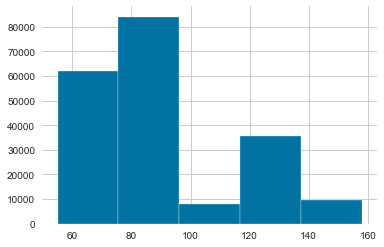

In [25]:
# A Histogram
df_responders.total_spent.hist(bins=5)

<AxesSubplot:>

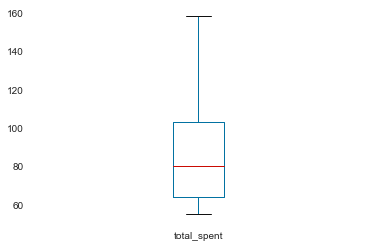

In [26]:
# A Boxplot
df_responders.total_spent.plot(kind='box')

### 5.2 Calculating Purchase Frequency 

#### For instance, consider this player 

#### installed base game on: day 100 

#### installed first DLC on: day 200

#### installed second DLC on: day 400

#### His purchase frequency is mean of (200-100) and (400-200), which is 150.



In [27]:
#defining the function to calculate return_freq for a player

def calc_diff_days(row):
    row=list(row.sort_values(ascending=False))          #first, sort all installs in descending order, and convert to list
    i=0
    diff_arr=[]
    
    while (i<8):                                        # there are 8 installables
        diff=row[i]-row[i+1]
        if row[i]!=-1:                                  # -1 signifies nans or not installed
            diff_arr.append(diff)
        else: break                                     # don't want to consider -1's for mean
        i+=1

    freq=np.mean([x for x in diff_arr if x !=0][:-1])   # remove 0, signifying same date installs
    return(freq)   


In [28]:
# run the function for all players
df_responders['purchase_freq']=df_responders[cols_purchase].apply(lambda row:calc_diff_days(row),axis=1)


C:\Users\nishant\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\nishant\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:>

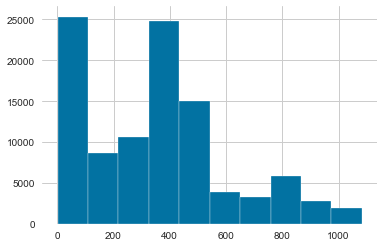

In [29]:
df_responders['purchase_freq'].hist()

In [30]:
df_responders.fillna(-1,inplace=True)

### 5.3 Clustering to identify appropriate segments

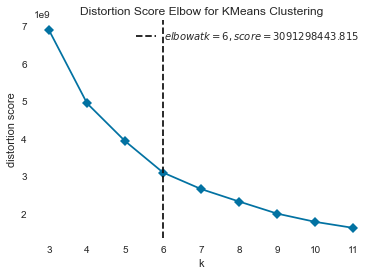

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
cols=['ACTIVEDAYS','n_response','LASTACTIVEDAY','total_spent', 'purchase_freq']   # metrics of interst for modified RFM analysis

#KElbowVisualizer helps identify optimum numbr of clusters/segments
visualizer = KElbowVisualizer(KMeans(init='k-means++'), k=(3,12), timings=False)
visualizer.fit(df_responders[cols])        # Fit the data to the visualizer
visualizer.show()

<font color=blue><h4> 5 or 6 seems a reasonable number of clusters. I choose 5.</h4></font>

In [32]:
# k-means to cluster the players in 5 segments
kmeans = KMeans(n_clusters=5, init='k-means++').fit(df_responders[cols])

In [33]:
# Assigning each player a custer number
df_responders['Cluster']=kmeans.predict(df_responders[cols])

#### Visualizing the players vs their cluster

<AxesSubplot:xlabel='Component1', ylabel='Component2'>

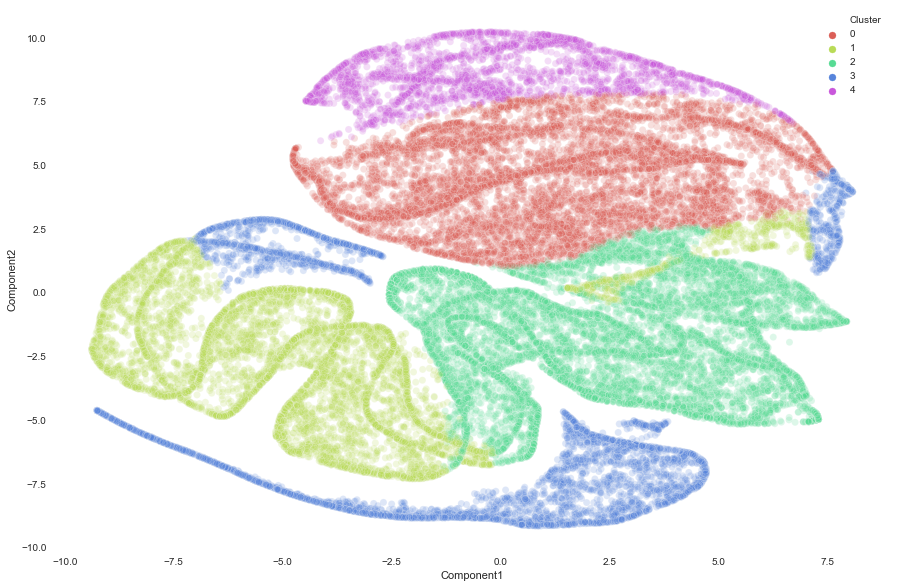

In [34]:
# taking a subset of data for visual
X_tr, X_tt, Y_tr, Y_tt = train_test_split(df_responders[cols],df_responders.Cluster,test_size=0.20,stratify=df_responders.Cluster)

#using tSNE to decompose into 2 components
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X_tt)
X_tt['Component1'] = tsne_results[:,0]
X_tt['Component2'] = tsne_results[:,1]
X_tt['Cluster']=Y_tt

#plotting
plt.figure(figsize=(15,10))
sns.scatterplot(x="Component1", y="Component2",hue="Cluster",palette=sns.color_palette("hls", df_responders['Cluster'].nunique()),
    data=X_tt,legend="full",alpha=0.2)

#### The clusters thus formed do look visually dissimilar. That signifies a job well done.

### 5.4 Segmenting Non-responders
#### Non-responders make-up 60% of the players, we can't ignore them, right!?
#### However, we only have recency and frequency metrics for them.

In [35]:
df_non_resp=df_days[df_days.ep_or_dlc_responder==0][['PLAYERID','LASTACTIVEDAY','ACTIVEDAYS','INSTALLDATE']]
df_non_resp.head()

,PLAYERID,LASTACTIVEDAY,ACTIVEDAYS,INSTALLDATE
0,3316379,500,1,500
1,3316386,504,3,500
2,3316394,684,115,500
3,3888460,1138,112,558
5,3316418,501,2,500


<AxesSubplot:>

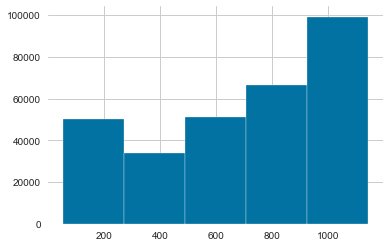

In [36]:
#Check if they played recently
df_non_resp.LASTACTIVEDAY.hist(bins=5)

In [37]:
df_non_resp.LASTACTIVEDAY.describe(percentiles=[.5,.75,.9,.95,.99])

count    300896.000000
mean        695.978893
std         340.585918
min          55.000000
50%         788.000000
75%         997.000000
90%        1104.000000
95%        1131.000000
99%        1141.000000
max        1141.000000
Name: LASTACTIVEDAY, dtype: float64

#### This shows more activity in later part of the study period, meaning less players have given up the game recently. 
#### Hence, they can still be targeted for marketing.

<AxesSubplot:>

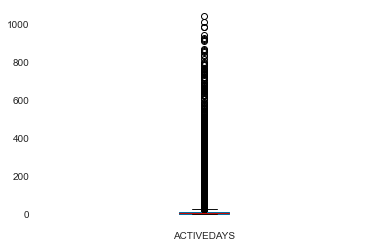

In [38]:
# A boxplot to check if they played frequently
df_non_resp.ACTIVEDAYS.plot(kind='box')

#### Many outliers, eh!? Let's dig deeper.

In [39]:
#getting percentiles
df_non_resp.ACTIVEDAYS.describe(percentiles=[.5,.9,.95,.99])

count    300896.000000
mean         11.909221
std          25.677992
min           1.000000
50%           5.000000
90%          26.000000
95%          41.000000
99%         104.000000
max        1041.000000
Name: ACTIVEDAYS, dtype: float64

In [40]:
df_non_resp[df_non_resp.LASTACTIVEDAY>600].shape

(181757, 4)

#### This shows that while most players played only for a little while, there are outliers who are playing regularly.

#### Looking at the plots, it makes sense to make two segments here,
#### Cluster 5: (LASTACTIVEDAY>=1000
#### Cluster 6: LASTACTIVEDAY<1000

In [41]:
# Looking at histogram and boxplots, I selected thresholds at ACTIVEDAYS=41 and LASTACTIVITY=600 days.
df_non_resp['Cluster']=df_non_resp.LASTACTIVEDAY.map(lambda x:5 if x>1000 else 6)

#### With just two metrics here, we can visualize thresholds using a simple scatter plot.

<AxesSubplot:xlabel='LASTACTIVEDAY', ylabel='ACTIVEDAYS'>

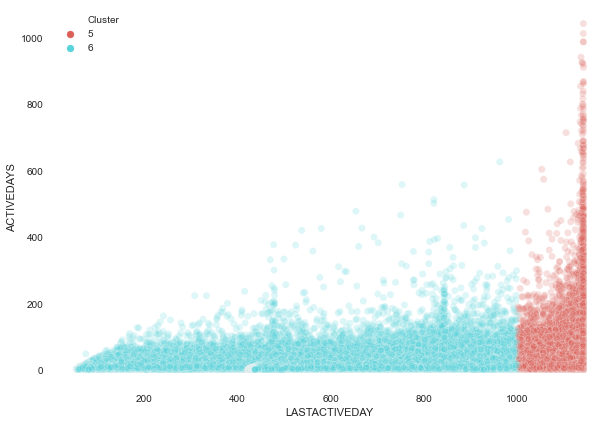

In [42]:
# Scatter Plot for ACTIVEDAYS VS LASTACTIVITY
plt.figure(figsize=(10,7))
sns.scatterplot(x="LASTACTIVEDAY", y="ACTIVEDAYS",hue="Cluster",palette=sns.color_palette("hls", 2),data=df_non_resp,legend="full",alpha=0.2)

## 6. Understanding the customer segments and preparing a strategy

In [43]:
# Let's collect all the clusters/segments

# responders
cnt_resp=df_responders['Cluster'].value_counts().reset_index()  # taking count of responding players in a segment
cnt_resp.columns=['Cluster','Player_count']

clus=pd.DataFrame()
clus['Cluster']=[i for i in range(7)]                           # since there are 7 clusters
clus=pd.merge(clus,cnt_resp,how='left',on='Cluster')
clus=pd.concat([clus,pd.DataFrame(kmeans.cluster_centers_,columns=cols).round(1)],axis=1)   #joining in the cluster centers or means

# non-responders
clus_nresp=df_non_resp.groupby('Cluster').agg({'PLAYERID':'count','LASTACTIVEDAY':np.mean,'ACTIVEDAYS':np.mean}).reset_index().round(1)
clus_nresp.rename(columns={'PLAYERID':'Player_count'},inplace=True)

# joining both
clus.set_index('Cluster', inplace=True)
clus.update(clus_nresp.set_index('Cluster'), join='left', overwrite=True)
clus.reset_index(inplace=True)
clus.fillna(0,inplace=True)

# show
clus

,Cluster,Player_count,ACTIVEDAYS,n_response,LASTACTIVEDAY,total_spent,purchase_freq
0,0,49597.0,92.8,2.9,1034.8,115.2,410.5
1,1,44202.0,14.7,1.5,861.0,72.5,13.5
2,2,58765.0,29.6,1.7,1080.8,85.7,27.4
3,3,31201.0,14.9,1.5,476.7,65.0,33.6
4,4,15339.0,49.6,1.6,1009.6,89.5,821.5
5,5,73898.0,19.6,0.0,1085.5,0.0,0.0
6,6,226998.0,9.4,0.0,569.2,0.0,0.0


<b>1.	Segment 0</b>

1.1.	Less active

1.2.	Last played long back

1.3.	Has forgotten the game

1.4.	In-game marketing won’t work!


<b>2.	Segment 1</b>

2.1.	Highly Active in playing and spending

2.2.	Installs new content regularly

2.3.	Can’t Lose Him!

2.4.	Target with all you can!


<b>3.	Segment 2</b>

3.1.	Less active in general, but has been active recently

3.2.	Won’t shy away from spending

3.3.	Aggressive Marketing needed!


<b>4.	Segment 3</b>

4.1.	Moderately active in gaming

4.2.	Doesn’t mind spending

4.3.	But purchases new packs once in eons!

4.4.	Stable Cohort, marketing probably won’t work!


<b>5.	Segment 4</b>

5.1.	Relatively low Activity

5.2.	But Moderate Spending

5.3.	Seen fairly recently

5.4.	Could attrite soon, need to re-engage

5.5.	Pitch in new features!


<b>6.	Segment 5</b>

6.1.	Non-Responder

6.2.	Less Active

6.3.	But seen recently

6.4.	May become a responder soon

6.5.	Target Aggressively!


<b>7.	Segment 6</b>

7.1.	Long time Non-Responder

7.2.	Very low activity

7.3.	Have been attrited for sure 

7.4.	Marketing will be money drain!

In [51]:
results=pd.concat([df_responders[['PLAYERID','Cluster']],df_non_resp[['PLAYERID','Cluster']]],axis=0)
results.to_csv('results.csv')

(500000, 2)